### Digital Imaging and Communications in Medicine (DICOM)
- Dicom is a standard in medical imaging.
- Python package pydicom is used to view and process dicom files.
- In this notebook we display the contours and calculate their volume.
#### Data we have
- A single CT scan or MRI produces multiple images called slices
- We usually have a RT Structure (RS) file containing the information of the countours of the different ROI (Region of Interest) sequences
- The contours are a way of segmenting the image into ROIs

In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dicom_contour.contour import *
import math
from shapely.geometry import Polygon
import zipfile
import os
from scipy import spatial
import scipy.ndimage as scn

In [18]:
# path is where the RS and the folder with slices is present
path ='001-002923_PHASE2'
# CT path is the path to the folder with the dcm files (slices)
CT_path = path + '/' + 'CT'

In [22]:
# get_contour_file gives the contour file in the folder
contour_file = get_contour_file(path)
print('The contour_file is: ',contour_file)

The contour_file is:  RS010001.dcm


In [25]:
# Read the contour_file
contour_file_data = dicom.read_file(path + '/' + 'RP010001.dcm')

- The Dicom files have a tree line structure, explore with .dir() to see all the availale methods

In [26]:
contour_file_data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Ion Plan Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.840.1.114337.71094328341.6941.20181017095825.3.0
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.4.2
(0002, 0013) Implementation Version Name         SH: 'ITC_DC_04083101'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20181017'
(0008, 0013) Instance Creation Time              TM: '095825'
(0008, 0014) Instance Creator UID                UI: 2.16.840.1.114337
(0008, 0016) SOP Class UID                       UI: RT Ion Plan Storage
(0008, 0018) SOP Instance UID  

In [21]:
ROI_names = get_roi_names(contour_file_data)
print(ROI_names)

['PTV 3MM NEW 3-1-17', 'OAR BR PL NEW 2 mm', 'Lung_L1 3-1', 'Lung_R1 3-1', 'TOTAL_LUNGS', 'patient', 'BRAC PLEXUS mim new 3-1-1', 'C4 NEW', 'C5 NEW', 'C6 NEW', 'C7 NEW', 'cord new 3-1-17', 'cord.5   3-17', 'CTV 5MM NEW3-1-17', 'ESO PRABHU NEW 3-1-17', 'GTV R SCIC LN NEW 3-1-17', 'ptv-eso-skin', 'skin.3  3-1-17', 'T1 NEW', 'TABLE', 'PTV COMP', 'M1', 'M2', 'M3', 'I1', 'Isocenter 8']


In [6]:
ESOPHAGUS_ROI_idx = ROI_names.index('ESOPHAGUS')
ESOPHAGUS_ROI_idx

12

##### slice_contour_UID
- We will match all the images/slices of MRI that are associated with a specific ROI based on this `Referenced SOP Instance UID` info from the slice_contour_datasets and the `Media Storage SOP Instance UID` info from the MRI slices.

In [8]:
ESOPHAGUS_contour_dataset = contour_file_data.ROIContourSequence[ESOPHAGUS_ROI_idx]
ESOPHAGUS_contour_dataset.ContourSequence[0].ContourData
# This shows the xyz coordinates of the contour of a particular slice. Here we are looking at the slice zero of Esophagus

[0.7, 11.5, -80.0000, 1.3, 12.1, -80.0000, 2.6, 12.1, -80.0000, 3.8, 10.8, -80.0000, 6.4, 10.8, -80.0000, 7.7, 9.6, -80.0000, 8.9, 9.6, -80.0000, 10.2, 8.3, -80.0000, 11.5, 8.3, -80.0000, 12.7, 7.0, -80.0000, 14.0, 7.0, -80.0000, 17.2, 3.8, -80.0000, 17.2, -0.0, -80.0000, 14.0, -3.1, -80.0000, 10.2, -3.1, -80.0000, 8.9, -1.9, -80.0000, 7.7, -1.9, -80.0000, 6.4, -0.6, -80.0000, 3.8, -0.6, -80.0000, -1.9, 5.1, -80.0000, -1.9, 10.2, -80.0000, -1.2, 10.8, -80.0000, -0.0, 10.8, -80.0000, 0.7, 11.5, -80.0000]

In [9]:
def contourUID_2_CT_fname(slice_contour_UID, CT_path):
    """loops through all the files inthe CT_path and returns the slice 
        whoose SOPInstanceUID matches with the refrenced SOP instance UID"""
    for CT_fname in os.listdir(CT_path):
        CT_file = dicom.read_file(os.path.join(CT_path, CT_fname))
        CT_UID = CT_file.SOPInstanceUID
        if CT_UID == slice_contour_UID:
            return CT_fname

In [10]:
ESOPHAGUS_slice0_contour_UID = ESOPHAGUS_contour_dataset.ContourSequence[0].ContourImageSequence[0].ReferencedSOPInstanceUID                     
print('The dcm file corresponding to the slice 0 of Esophagus is :', contourUID_2_CT_fname(ESOPHAGUS_slice0_contour_UID,CT_path))

The dcm file corresponding to the slice 0 of Esophagus is : CT010060.dcm


In [11]:
def get_ROI_fnames_contour(path, ROI:str):
    """Given a path and the ROI name, it returns the
    list of tuples of all slices corresponding to the ROI and their contour array of xyz coords"""
    contour_file = get_contour_file(path)
    contour_FileDataset = dicom.read_file(os.path.join(path, contour_file))
    ROI_names = get_roi_names(contour_FileDataset)
    ROI_names = [i.upper() for i in ROI_names]  # changed to upper case to avoid case matching errors
    ROI_idx = ROI_names.index(ROI.upper()) # changed to uppercase
    ROI_contour_dataset = contour_FileDataset.ROIContourSequence[ROI_idx]
    ROI_contour_sequence = ROI_contour_dataset.ContourSequence
    ROI_contour_UIDs = [slice_contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID \
                        for slice_contour_dataset in ROI_contour_sequence]
    CT_path = os.path.join(path,"CT")
    ROI_fname_contour = []
    # loops through UIDs and append the tuple with dicom and the counour coordinates
    for i in range(len(ROI_contour_UIDs)):
        ROI_fname_contour.append((contourUID_2_CT_fname(ROI_contour_UIDs[i], CT_path),ROI_contour_sequence[i].ContourData))
    
    return ROI_fname_contour

In [17]:
dicom.read_file(CT_path+'/'+'CT010060.dcm')

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 196
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.16.840.1.114337.71094328341.5859.20181017133957.0.26
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.4.2
(0002, 0013) Implementation Version Name         SH: 'ITC_DC_04083101'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'SECONDARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20181017'
(0008, 0013) Instance Creation Time              TM: '133957'
(0008, 0014) Instance Creator UID                UI: 2.16.840.1.114337
(0008, 0016) SOP C

In [12]:
ESOPHAGUS_CT_fnames = get_ROI_fnames_contour(path, 'Esophagus')[0] 
print('dcm file and the contour xyz coordinates corresponding to slice zero')
print(ESOPHAGUS_CT_fnames)

dcm file and the contour xyz coordinates corresponding to slice zero
('CT010060.dcm', [0.7, 11.5, -80.0000, 1.3, 12.1, -80.0000, 2.6, 12.1, -80.0000, 3.8, 10.8, -80.0000, 6.4, 10.8, -80.0000, 7.7, 9.6, -80.0000, 8.9, 9.6, -80.0000, 10.2, 8.3, -80.0000, 11.5, 8.3, -80.0000, 12.7, 7.0, -80.0000, 14.0, 7.0, -80.0000, 17.2, 3.8, -80.0000, 17.2, -0.0, -80.0000, 14.0, -3.1, -80.0000, 10.2, -3.1, -80.0000, 8.9, -1.9, -80.0000, 7.7, -1.9, -80.0000, 6.4, -0.6, -80.0000, 3.8, -0.6, -80.0000, -1.9, 5.1, -80.0000, -1.9, 10.2, -80.0000, -1.2, 10.8, -80.0000, -0.0, 10.8, -80.0000, 0.7, 11.5, -80.0000])


- Once we have the coordinates of the contours, we need to convert them to pixels so that they can be viewed
- Used the imageposition to get the origin coordinates of the slice 
- Used the pixel spacing and origin position for the conversion

In [13]:
def coords_to_pixel(coords,dcm):
    """ Given the coordinates of the countour and the dcm file we convert it to a pixel array of ones and zeros
    We need to get the origin and spacing of the pixel array to map the coordinates"""
    data = pydicom.dcmread(dcm)
    image_pixel = data.pixel_array
    x0 = coords[0]
    y0 = coords[1]
    xy = []
    for i in range(0, len(coords), 3):
        x = coords[i]
        y = coords[i+1]
        z = coords[i+2]
        xy.append((x,y))
    x_origin, y_origin = data.ImagePositionPatient[0],data.ImagePositionPatient[1]
    # Gives the origin in the pixel array
    spacing = data.PixelSpacing
    contour_pixel = np.zeros((image_pixel.shape))
    
    # Mapping the contour coordinates to pixel array coordinates
    for x,y in xy:
        xi = int((x - x_origin)/spacing[0])
        yi = int((y - y_origin)/spacing[1])
        contour_pixel[xi,yi]=1   # the pixel for contours is set as one the remaining stay at zero
    return contour_pixel

In [14]:
coords = ESOPHAGUS_CT_fnames[1]
dicom_file = ESOPHAGUS_CT_fnames[0]
dcm = os.path.join(path,'CT',dicom_file)
contour_pixel = coords_to_pixel(coords,dcm)
contour_pixel

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

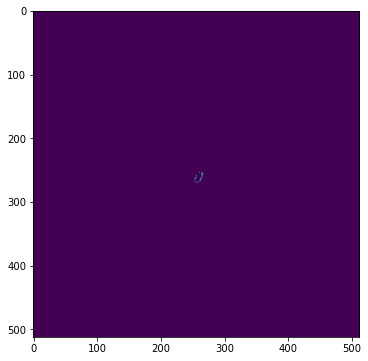

In [15]:
# Displaying the contour
plt.figure(figsize=(6,6))
plt.imshow(contour_pixel)

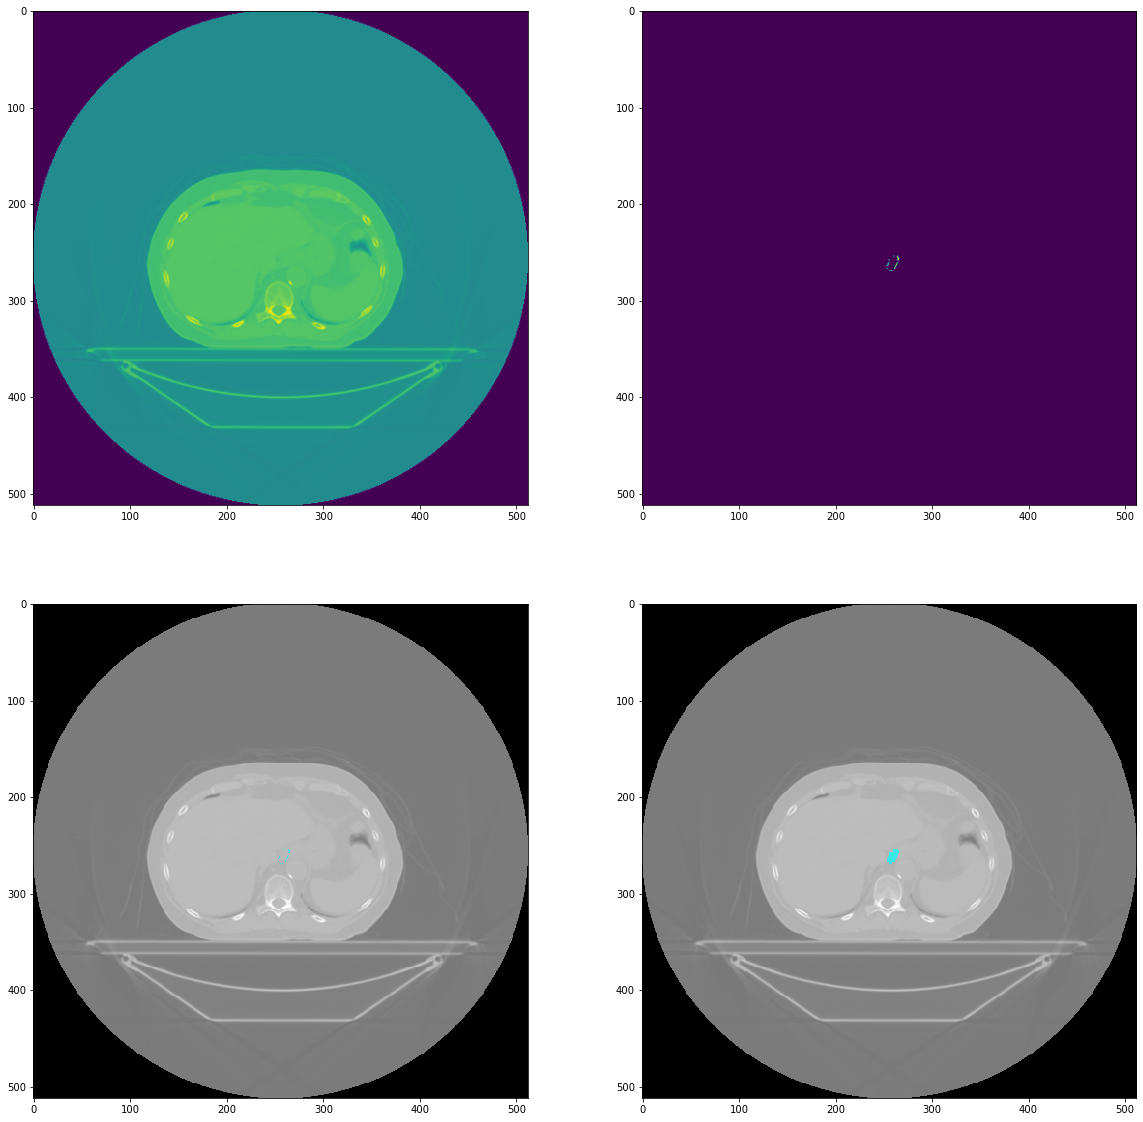

In [19]:
def display_contour(path,ROI,n=0):
    """ Given the path and ROI display the dicom slice with the contour, n shows the no of the slice"""
    
    dicom_file,coords = get_ROI_fnames_contour(path,ROI)[n]
    dcm = os.path.join(path,'CT',dicom_file)
    image_pixel = pydicom.dcmread(dcm).pixel_array
    contour_pixel = coords_to_pixel(coords,dcm)
    fig,axs = plt.subplots(2,2, figsize=(20,20))
    axs[0,0].imshow(image_pixel)
    axs[0,1].imshow(contour_pixel)
    masked_contour_arr = np.ma.masked_where(contour_pixel == 0, contour_pixel)
    axs[1,0].imshow(image_pixel, cmap='gray', interpolation='none')
    axs[1,0].imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.7)
    filled_contour = np.array([scn.binary_fill_holes(y).astype(int) if y.max() == 1 else y for y in contour_pixel])
    filled_contour_T = np.array([scn.binary_fill_holes(y).astype(int) if y.max() == 1 else y for y in filled_contour.T])
    masked_contour_arr = np.ma.masked_where(filled_contour_T.T == 0, filled_contour_T.T)
    axs[1,1].imshow(image_pixel, cmap='gray', interpolation='none')
    axs[1,1].imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.7)
    plt.show()
display_contour(path,'Esophagus',n=0)

In [20]:
def area(coords):
    """Given the xyz coords of the contour, calculate the area of the contour"""
    x = []
    y = []
    # looping though to append the x and y coords, ignoring z since it is constant for each slice
    for i in range(0, len(coords), 3):
        x.append(coords[i])   
        y.append(coords[i+1])

    pgon = Polygon(zip(x, y))
    return pgon.area

In [21]:
def volume(path, ROI):
    """ Given the path and ROI return the volume of the ROI by looping through all the slices corresponding to the ROI
    and adding it to get the total volume. Volume of slice is calculated by multiplying the area with the slice thickness"""
    
    fnames_coords = get_ROI_fnames_contour(path,ROI) # Gives all the slices and corresponding contour coordinates
    vol = 0
    
    for dicom_file,coord  in fnames_coords:
        area_contour = area(coord)
        thickness = float(pydicom.dcmread(os.path.join(path,'CT',dicom_file)).SliceThickness)
        vol = vol + area_contour*thickness
    return vol

In [22]:
# Volume of Esophagus in cubic mm
volume(path,'esophagus') 

33181.825000000004

In [23]:
# This matches with the volume given in the RT structure file
contour_file_data.StructureSetROISequence[ESOPHAGUS_ROI_idx].ROIVolume

'33.2'

In [ ]:
# Volume calculation using the coordinates matches with the volume extracted from the sequence.

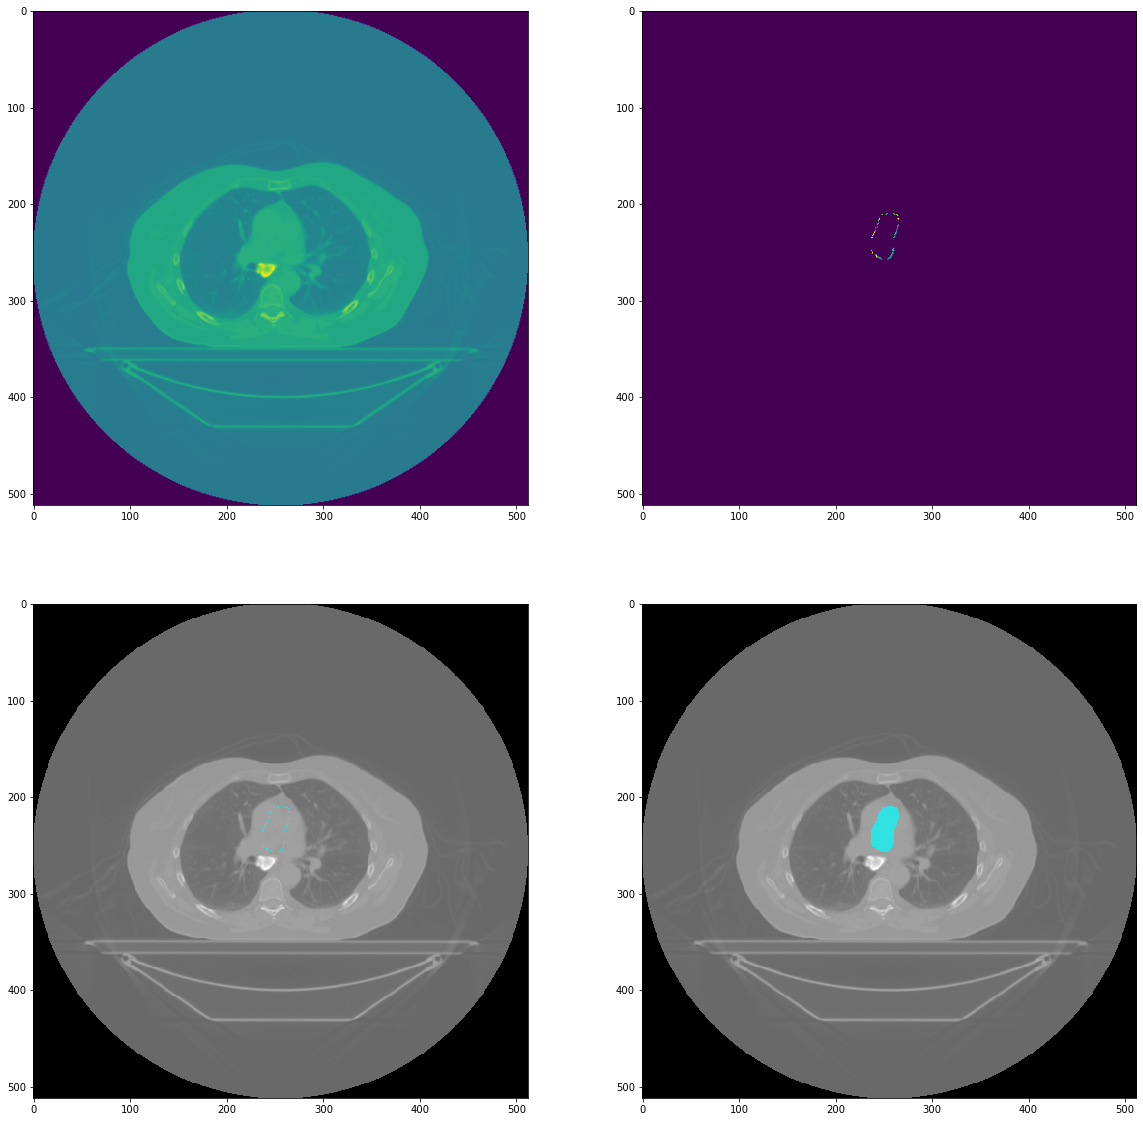

In [24]:
# Using the functions to display CTV
plt.savefig('output.png', dpi=300)display_contour(path,'CTV',n=0)

In [25]:
print('Volume of the contour CTV im cubic mm: ',volume(path,'CTV'))

Volume of the contour CTV im cubic mm:  160481.95


In [26]:
# Verifying the volume with the volume in the file
CTV_ROI_idx = ROI_names.index('CTV')
contour_file_data.StructureSetROISequence[CTV_ROI_idx].ROIVolume

'160.5'

In [27]:
contour_file_data.StructureSetROISequence[CTV_ROI_idx]

(3006, 0022) ROI Number                          IS: '12'
(3006, 0024) Referenced Frame of Reference UID   UI: 1.2.840.113619.2.55.3.2831167414.367.1418821660.64.12965.1
(3006, 0026) ROI Name                            LO: 'CTV'
(3006, 0028) ROI Description                     ST: 'CTV'
(3006, 002c) ROI Volume                          DS: '160.5'
(3006, 0036) ROI Generation Algorithm            CS: 'MANUAL'

### The volume is calculated and verified with the volume given in the RT Structure file for both CTV and Esophagus

### In this part we aim to Calculate the Distance between two ROIs
- We collect all the coordinates of an ROI into a numpy array
- Calculate the distance between all possible combinations of points between two ROIs
- Identify the distance between centroid of the ROIs
- Identify the shortest distance between the ROIs

In [28]:
def coords(ROI,contour_FileDataset):
    """Given the name of the ROI and the contour data set, it returns an np array of all 
    coordinates collected from all the slices of the ROI"""
    #contour_file = get_contour_file(path)
    #contour_FileDataset = dicom.read_file(os.path.join(path, contour_file))
    ROI_names = get_roi_names(contour_FileDataset)
    ROI_names = [i.upper() for i in ROI_names]  # changed to upper case to avoid case matching errors
    ROI_idx = ROI_names.index(ROI.upper()) # changed to uppercase
    ROI_contour_dataset = contour_FileDataset.ROIContourSequence[ROI_idx]
    ROI_contour_sequence = ROI_contour_dataset.ContourSequence
    size = []
    for slice in ROI_contour_sequence:
        size.append(int(slice.NumberOfContourPoints))
        
    s = sum(size) 
    # create an empty numpy array of size equal to number of Countour points in all slices together
    roi_coords = np.empty((s,3))
    a = 0
    for slice in ROI_contour_sequence:
        slice_coord = np.array(slice.ContourData).reshape((-1,3)) 
        #reshapes it to have each row as x,y,z coord of a point
        b = a + len(slice_coord)
        roi_coords[a:b] = slice_coord # adds the contour points to the array
        a = b
    return roi_coords  

In [29]:
coords_Esophagus = coords('Esophagus',contour_file_data)

In [30]:
coords_Esophagus[100]

array([ -7.6,  17.2, -72.5])

In [31]:
coords_CTV = coords('CTV',contour_file_data)

In [32]:
coords_CTV[100]

array([-34.2, -23.5,  22.5])

#### We got all the coordinates from both contours, we will calculate the distance between the centroids

In [33]:
def centroid(points):
    """Returns the centroid of a set of points"""
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    z = [p[2] for p in points]
    centroid = (sum(x) / len(points), sum(y) / len(points), sum(z) / len(points) )
    return centroid

In [34]:
# Distance between centroids in mm
cen_Esophagus = np.array(centroid(coords_Esophagus))
cen_CTV = np.array(centroid(coords_CTV))
cen_dist = np.linalg.norm(cen_Esophagus-cen_CTV)
print("Distance between the centroids of Esophagus and CTV in mm is: ",cen_dist)

Distance between the centroids of Esophagus and CTV in mm is:  50.12235456061901


In [35]:
%%time
distances = np.empty(coords_CTV.shape[0] * coords_Esophagus.shape[0])
for i in range(coords_CTV.shape[0]):
    for j in range(coords_Esophagus.shape[0]):
            distances[i*coords_Esophagus.shape[0]+j] = np.linalg.norm(coords_CTV[i] - coords_Esophagus[j])
print(distances[0:10])

[112.75819261 113.03826786 113.65016498 114.22578518 115.50467523
 116.1740935  116.78912621 117.49382963 118.18058216 118.86572256]
CPU times: user 15.8 s, sys: 77.7 ms, total: 15.9 s
Wall time: 15.9 s


In [36]:
def distance(ROI1, ROI2, contour_FileDataset):
    """Returns the distance between the centroids and the minimum distance between the ROIs
    Also gives the no of points of intersection"""
    #Get the coordinates of ROIs from all slices
    Intersection_points = 0
    ROI1_coords = coords(ROI1, contour_FileDataset)
    ROI2_coords = coords(ROI2, contour_FileDataset)
    
    #calculates Eucledian distances between all possible combinations
    # of contour points between the ROIs
    distances = spatial.distance.cdist(ROI1_coords, ROI2_coords)
    
    min_dist = distances.min()
    Intersection_points = (distances == 0).sum()
    ROI1_cen = np.array(centroid(ROI1_coords))
    ROI2_cen = np.array(centroid(ROI2_coords))
    cen_dist = np.linalg.norm(ROI1_cen-ROI2_cen)
    return (cen_dist, min_dist,Intersection_points)   

In [37]:
%%time
print("Centroid and minimum distance between Esophagus and CTV")
distance('Esophagus', 'CTV', contour_file_data)

Centroid and minimum distance between Esophagus and CTV
CPU times: user 18 ms, sys: 10.2 ms, total: 28.3 ms
Wall time: 27.7 ms


(50.12235456061901, 0.0, 4)

In [38]:
%%time
print("Centroid and minimum distance between Esophagus and GTV-LUNG")
distance('Esophagus', 'GTV-LUNG', contour_file_data)

Centroid and minimum distance between Esophagus and GTV-LUNG
CPU times: user 7.71 ms, sys: 1.42 ms, total: 9.13 ms
Wall time: 7.9 ms


(106.41490750677089, 68.46196024070593, 0)

In [ ]:
spatial.distance.cdist

In [39]:
'GTV-MEDIA', 'GTV-LUNG'

('GTV-MEDIA', 'GTV-LUNG')

In [40]:
%%time
print("Centroid and minimum distance between Esophagus and GTV-MEDIA")
distance('Esophagus', 'GTV-MEDIA', contour_file_data)

Centroid and minimum distance between Esophagus and GTV-MEDIA
CPU times: user 22.7 ms, sys: 2.03 ms, total: 24.7 ms
Wall time: 22.7 ms


(37.64119014181722, 0.0, 1)